# GLM NEGATIVE BINOMIAL REGRESSION

## Load libraries

In [8]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import warnings

from scipy import stats

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [9]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Generate data

### Poisson data

In [3]:
# Mean Poisson values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# Create samples
q = 1000
df_pois = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                rng.poisson(theta_noalcohol_meds, q),
                rng.poisson(theta_alcohol_meds, q),
                rng.poisson(theta_noalcohol_nomeds, q),
                rng.poisson(theta_alcohol_nomeds, q),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(False, q),
                np.repeat(True, q),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(True, q),
            )
        ),
    }
)

In [4]:
(df_pois
 .groupby(["nomeds", "alcohol"])["nsneeze"]
 .agg(["mean", "var"])
)

mean        var
nomeds alcohol                   
False  False     1.047   1.127919
       True      2.986   2.960765
True   False     5.981   6.218858
       True     35.929  36.064023

### Negative binomial data

In [5]:
# Gamma shape parameter
alpha = 10


def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


# Create samples
n = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                get_nb_vals(theta_noalcohol_meds, alpha, n),
                get_nb_vals(theta_alcohol_meds, alpha, n),
                get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                get_nb_vals(theta_alcohol_nomeds, alpha, n),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(False, n),
                np.repeat(True, n),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(True, n),
            )
        ),
    }
)
df

,nsneeze,alcohol,nomeds
0,0,False,False
1,2,False,False
2,1,False,False
3,0,False,False
4,2,False,False
...,...,...,...
3995,46,True,True
3996,32,True,True
3997,45,True,True
3998,25,True,True


In [6]:
(df
 .groupby(["nomeds", "alcohol"])["nsneeze"]
 .agg(["mean", "var"])
)

mean         var
nomeds alcohol                    
False  False     1.008    1.169105
       True      2.934    3.855499
True   False     6.166    9.626070
       True     35.575  172.160536

### Visualize the data

C:\Users\bacos1\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


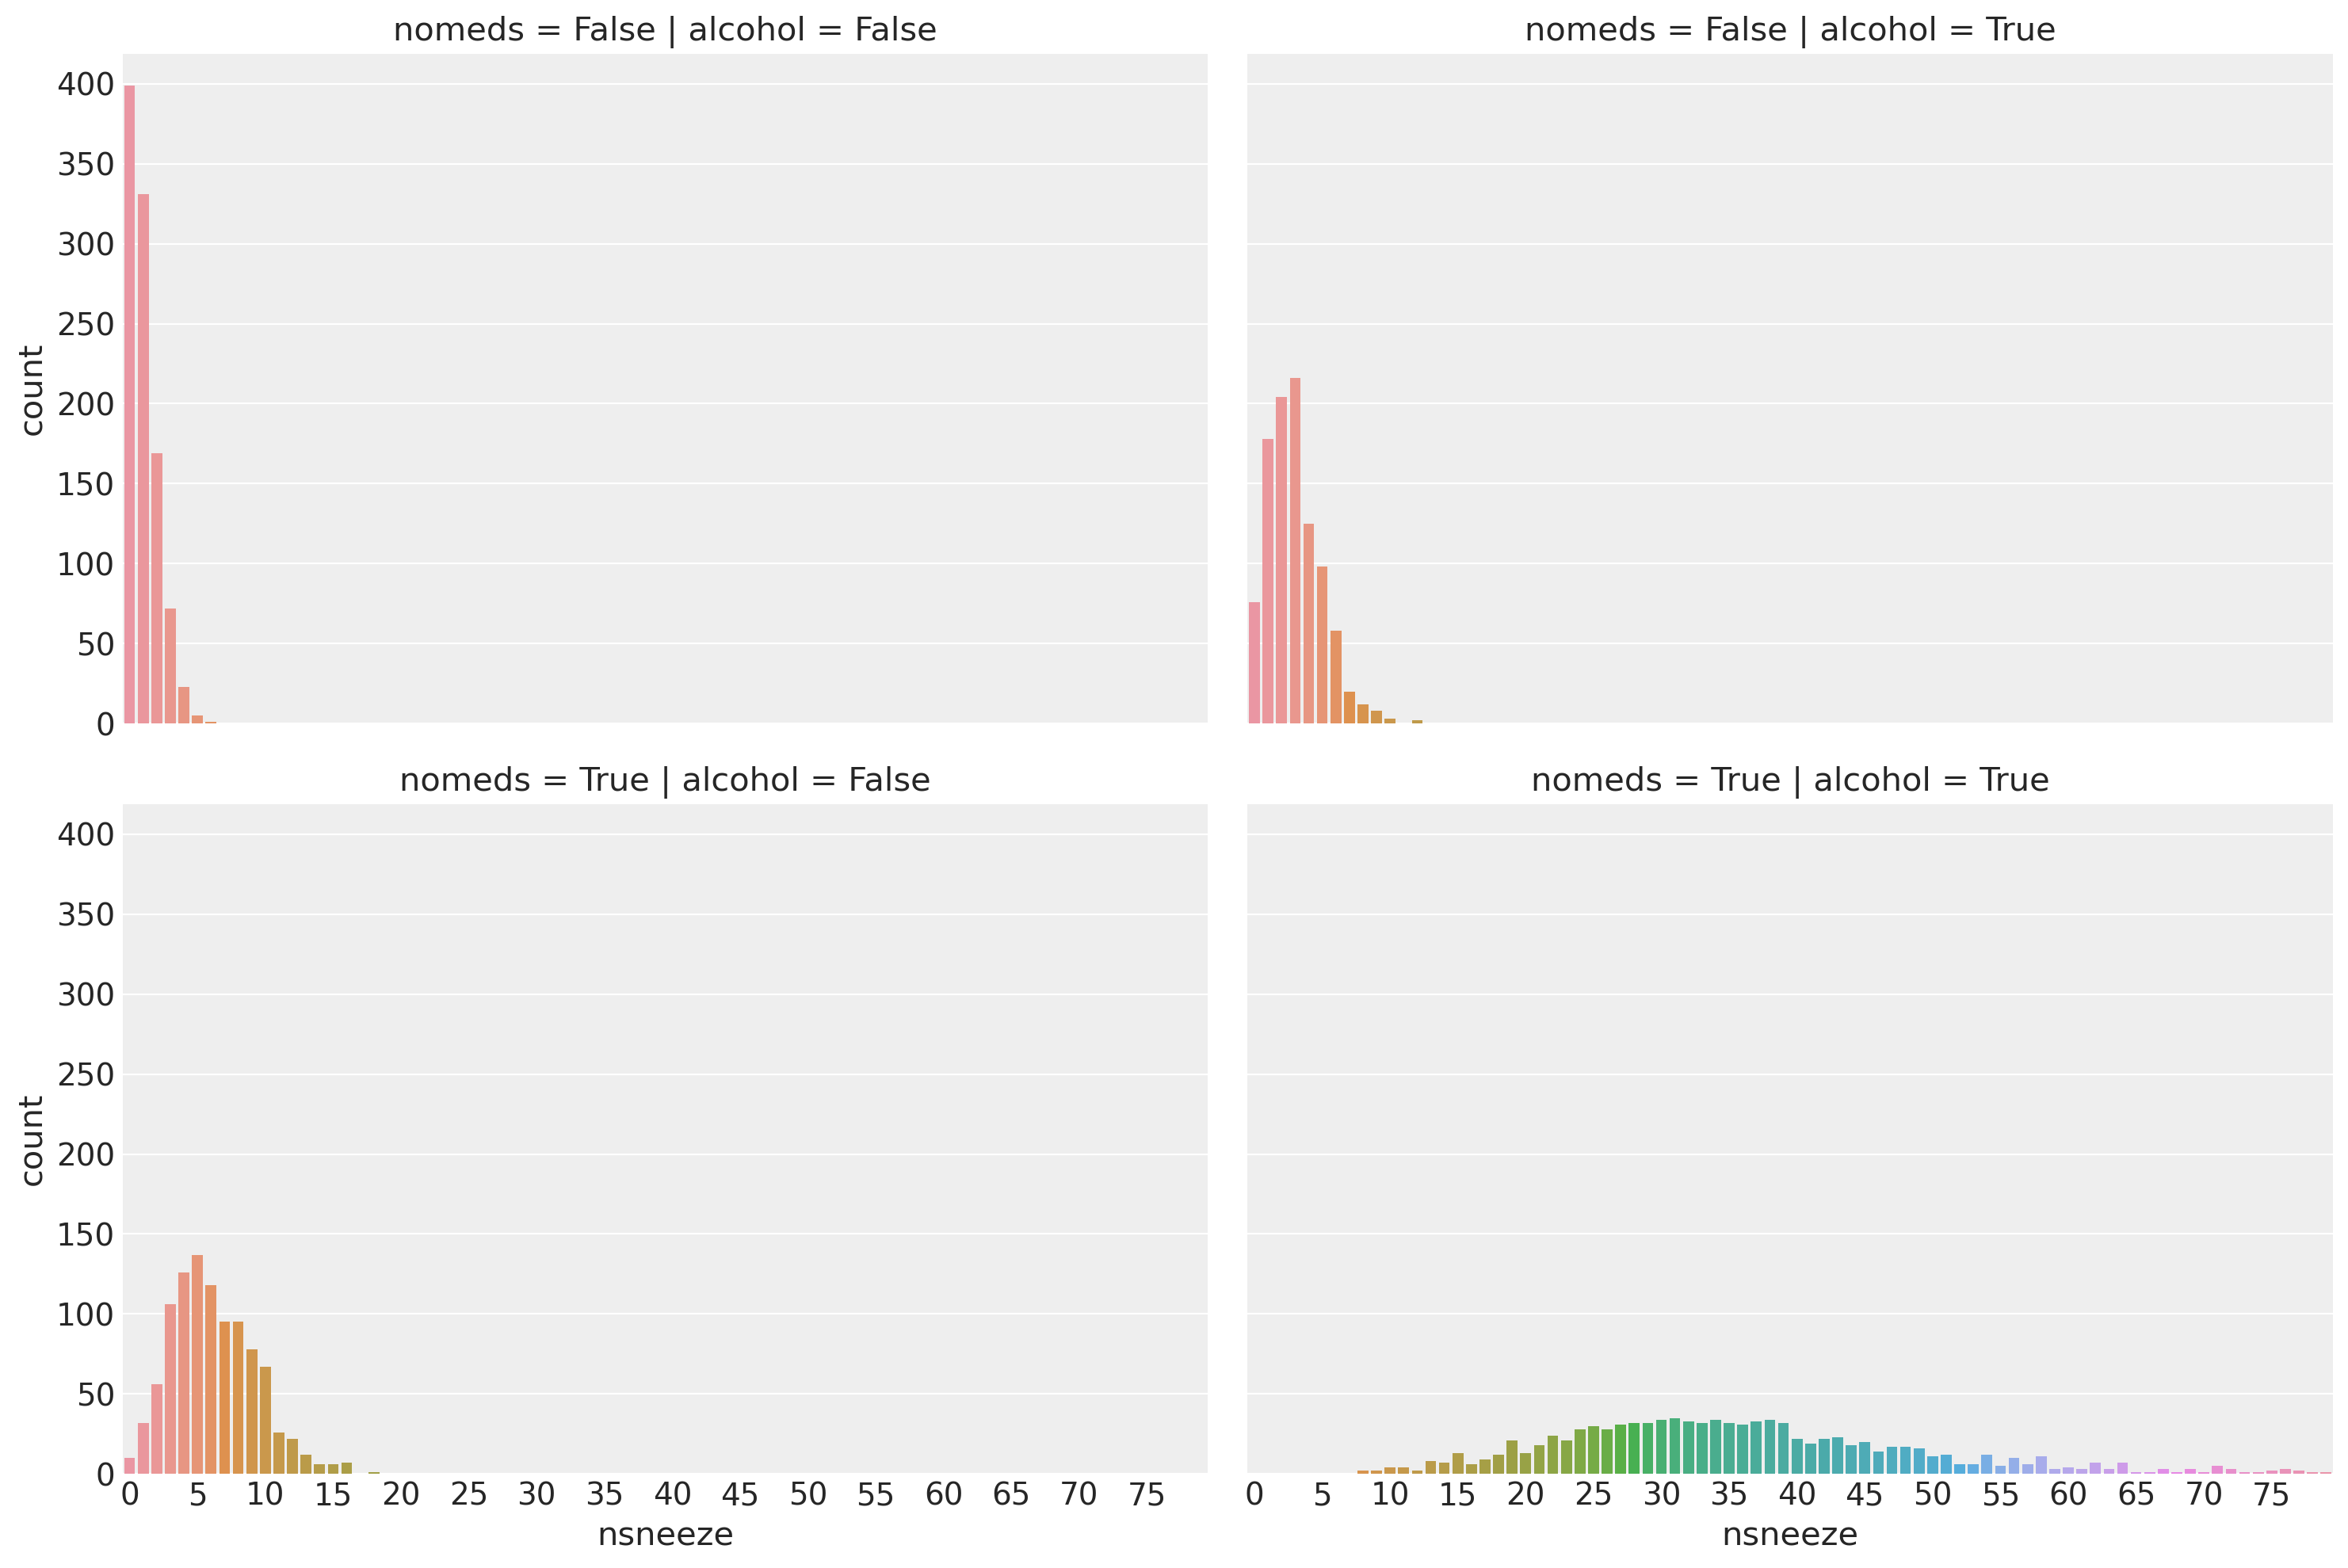

In [11]:
g = sns.catplot(x="nsneeze", row="nomeds", col="alcohol", data=df, kind="count", aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which="both")))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

## Negative binomial regression

### GLM Model

In [12]:
COORDS = {'regressor': ['nomeds', 'alcohol', 'nomdes:alcohool'], 'obs_idx': df.index}

In [ ]:
with pm.Model(coords = COORDS) as m_sneeze_inter:
    a = pm.Normal('intercept', mu = 0, sigma = 5)
    b = pm.Normal('slopes', mu = 0, sigma = 1, dims = 'regressor')
    alpha = pm.Exponential('alpha', 0.5)
    
    M = pm.ConstantData('nomeds', df.nomeds.to_numpy(), dims = 'obs_idx')
    A = pm.ConstantData('alcohol', df.alcohol.to_numpy(), dims = 'obs_idx')
    S = pm.ConstantData('nsneeze', df.nsneeze.to_numpy(), dims = 'obs_idx')
    
    lambda = pm.math(a + b[0] * M + b[1] * A + b[2] * M * A)